# SVM running with only VVR_1 and VVR_2

In [1]:
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_train_smote_12-06-2024.csv')
y_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_train_smote_12-06-2024.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_test_12-06-2024.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_test_12-06-2024.csv')

In [3]:
# Drop unnamed columns 
y_test = y_test.drop(columns='Unnamed: 0', axis=1)
X_train = X_train.drop(columns='Unnamed: 0', axis=1)
y_train = y_train.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)

In [4]:
print(list(X_train.columns))
print()
print(list(X_test.columns))

['Condition', 'Sum_456', 'Sum_1', 'Sum_2', 'AU01_r__sum_values', 'AU01_r__variance', 'AU01_r__standard_deviation', 'AU01_r__maximum', 'AU01_r__mean', 'AU01_r__root_mean_square', 'AU02_r__sum_values', 'AU02_r__variance', 'AU02_r__standard_deviation', 'AU02_r__maximum', 'AU02_r__mean', 'AU02_r__root_mean_square', 'AU04_r__sum_values', 'AU04_r__variance', 'AU04_r__standard_deviation', 'AU04_r__maximum', 'AU04_r__mean', 'AU04_r__root_mean_square', 'AU05_r__sum_values', 'AU05_r__variance', 'AU05_r__standard_deviation', 'AU05_r__maximum', 'AU05_r__mean', 'AU05_r__root_mean_square', 'AU06_r__sum_values', 'AU06_r__variance', 'AU06_r__standard_deviation', 'AU06_r__maximum', 'AU06_r__mean', 'AU06_r__root_mean_square', 'AU07_r__sum_values', 'AU07_r__variance', 'AU07_r__standard_deviation', 'AU07_r__maximum', 'AU07_r__mean', 'AU07_r__root_mean_square', 'AU09_r__sum_values', 'AU09_r__variance', 'AU09_r__standard_deviation', 'AU09_r__maximum', 'AU09_r__mean', 'AU09_r__root_mean_square', 'AU10_r__sum

In [5]:
columns_to_drop = ['Condition', 'Sum_456', 'AU01_r__sum_values', 'AU01_r__variance', 'AU01_r__standard_deviation', 'AU01_r__maximum', 'AU01_r__mean', 'AU01_r__root_mean_square', 'AU02_r__sum_values', 'AU02_r__variance', 'AU02_r__standard_deviation', 'AU02_r__maximum', 'AU02_r__mean', 'AU02_r__root_mean_square', 'AU04_r__sum_values', 'AU04_r__variance', 'AU04_r__standard_deviation', 'AU04_r__maximum', 'AU04_r__mean', 'AU04_r__root_mean_square', 'AU05_r__sum_values', 'AU05_r__variance', 'AU05_r__standard_deviation', 'AU05_r__maximum', 'AU05_r__mean', 'AU05_r__root_mean_square', 'AU06_r__sum_values', 'AU06_r__variance', 'AU06_r__standard_deviation', 'AU06_r__maximum', 'AU06_r__mean', 'AU06_r__root_mean_square', 'AU07_r__sum_values', 'AU07_r__variance', 'AU07_r__standard_deviation', 'AU07_r__maximum', 'AU07_r__mean', 'AU07_r__root_mean_square', 'AU09_r__sum_values', 'AU09_r__variance', 'AU09_r__standard_deviation', 'AU09_r__maximum', 'AU09_r__mean', 'AU09_r__root_mean_square', 'AU10_r__sum_values', 'AU10_r__variance', 'AU10_r__standard_deviation', 'AU10_r__maximum', 'AU10_r__mean', 'AU10_r__root_mean_square', 'AU12_r__sum_values', 'AU12_r__variance', 'AU12_r__standard_deviation', 'AU12_r__maximum', 'AU12_r__mean', 'AU12_r__root_mean_square', 'AU14_r__sum_values', 'AU14_r__variance', 'AU14_r__standard_deviation', 'AU14_r__maximum', 'AU14_r__mean', 'AU14_r__root_mean_square', 'AU15_r__sum_values', 'AU15_r__variance', 'AU15_r__standard_deviation', 'AU15_r__maximum', 'AU15_r__mean', 'AU15_r__root_mean_square', 'AU17_r__sum_values', 'AU17_r__variance', 'AU17_r__standard_deviation', 'AU17_r__maximum', 'AU17_r__mean', 'AU17_r__root_mean_square', 'AU20_r__sum_values', 'AU20_r__variance', 'AU20_r__standard_deviation', 'AU20_r__maximum', 'AU20_r__mean', 'AU20_r__root_mean_square', 'AU23_r__sum_values', 'AU23_r__variance', 'AU23_r__standard_deviation', 'AU23_r__maximum', 'AU23_r__mean', 'AU23_r__root_mean_square', 'AU25_r__sum_values', 'AU25_r__variance', 'AU25_r__standard_deviation', 'AU25_r__maximum', 'AU25_r__mean', 'AU25_r__root_mean_square', 'AU26_r__sum_values', 'AU26_r__variance', 'AU26_r__standard_deviation', 'AU26_r__maximum', 'AU26_r__mean', 'AU26_r__root_mean_square', 'AU45_r__sum_values', 'AU45_r__variance', 'AU45_r__standard_deviation', 'AU45_r__maximum', 'AU45_r__mean', 'AU45_r__root_mean_square']

In [6]:
X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

In [7]:
print(list(X_train.columns))
print()
print(list(X_test.columns))

['Sum_1', 'Sum_2']

['Sum_1', 'Sum_2']


In [8]:
# Convert the DataFrame to a 1-dimensional NumPy array
y_train= y_train.values.ravel()
y_test = y_test.values.ravel()

In [9]:
# Display each dataframe to verify the loading
print("X_train:")
display(X_train)

print("\nX_test:")
display(X_test)

X_train:


,Sum_1,Sum_2
0,12.000000,11.000000
1,11.000000,10.000000
2,8.000000,8.000000
3,8.000000,8.000000
4,8.000000,8.000000
...,...,...
253,10.591267,11.000000
254,13.316483,9.316483
255,9.826138,9.369604
256,15.873762,14.781560



X_test:


,Sum_1,Sum_2
0,10.0,9.0
1,14.0,12.0
2,9.0,8.0
3,17.0,19.0
4,10.0,9.0
...,...,...
79,10.0,12.0
80,9.0,8.0
81,10.0,10.0
82,12.0,10.0


# Optimized code

# Without SHAP and RFE 
Running the code below took 63 minutes. 

Test scores for each fold: [0.79069767 0.75581395 0.70930233]
Fold 1 score: 0.791, SD: 0.033
Fold 2 score: 0.756, SD: 0.033
Fold 3 score: 0.709, SD: 0.033
The mean score using nested cross-validation is: 0.752 ± 0.033
Fold 1 best parameters: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Fold 2 best parameters: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Fold 3 best parameters: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}

Best model parameters: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}

Evaluating best model on test set

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        57
           1       0.70      0.78      0.

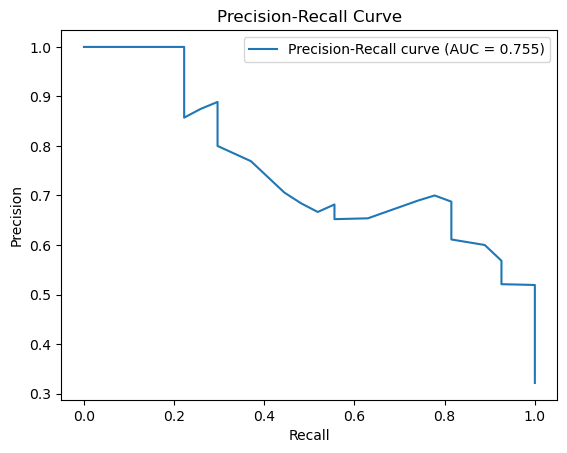

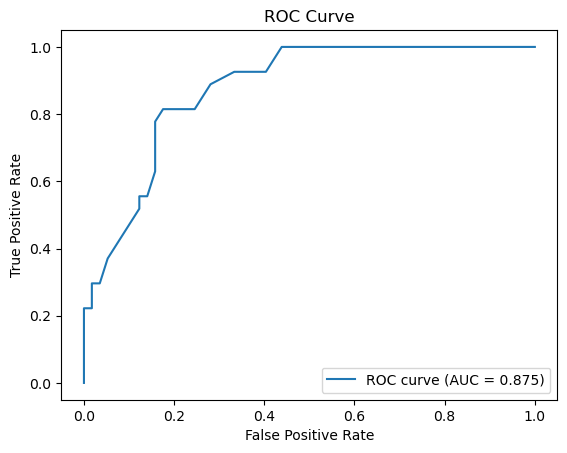

Test AUC-PR: 0.755


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

def build_pipeline():
    """Builds the machine learning pipeline with SVC."""
    model = SVC(probability=True, random_state=0)  # SVC with probability estimates
    return Pipeline(steps=[('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__C': [0.1, 1, 10, 100],  # Regularization parameter
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Kernel coefficient
        'classifier__class_weight': [{0: 0.75, 1: 1.49}, None],  # Class weights
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    for idx, score in enumerate(test_scores):
        print(f"Fold {idx + 1} score: {score:.3f}, SD: {test_score_std:.3f}")  # Print score and SD for each fold
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    # Print the best parameters for each fold
    for idx, result in enumerate(cv_results['estimator']):
        print(f"Fold {idx + 1} best parameters: {result.best_params_}")

    # Select the best model based on test scores
    best_fold_index = np.argmax(cv_results['test_score'])
    best_model = cv_results['estimator'][best_fold_index].best_estimator_
    best_params = cv_results['estimator'][best_fold_index].best_params_
    
    print(f"\nBest model parameters: {best_params}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    print(confusion_matrix(y_test, y_test_pred))  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score

    return y_test_pred, best_model

# Example usage (assuming X_train, y_train, X_test, y_test are already defined):
cv_results = perform_nested_cv(X_train, y_train)
y_test_pred, best_model = evaluate_model(cv_results, X_test, y_test)


In [13]:
print(y_test_pred)

[0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 1 1 1 1 0 0 0 0 1]


In [14]:
# Convert the NumPy array to a Pandas DataFrame
y_test_pred_df = pd.DataFrame(y_test_pred)

# Save the DataFrame to a CSV file
y_test_pred_df.to_csv('/Users/dionnespaltman/Desktop/V6/02_svm_y_test_pred_18-06-2024.csv', sep=',', index=False)

In [15]:
print(y_test_pred_df)

    0
0   0
1   1
2   0
3   1
4   0
.. ..
79  0
80  0
81  0
82  0
83  1

[84 rows x 1 columns]


In [10]:
# Load the dataframe from a CSV file
file_path = '/Users/dionnespaltman/Desktop/V6/02_svm_y_test_pred_18-06-2024.csv'  # Replace with your actual file path
y_test_pred = pd.read_csv(file_path)
print(y_test_pred.shape)
print(y_test_pred)

(84, 1)
    0
0   0
1   1
2   0
3   1
4   0
.. ..
79  0
80  0
81  0
82  0
83  1

[84 rows x 1 columns]


# New confusion matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_30379/677810150.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


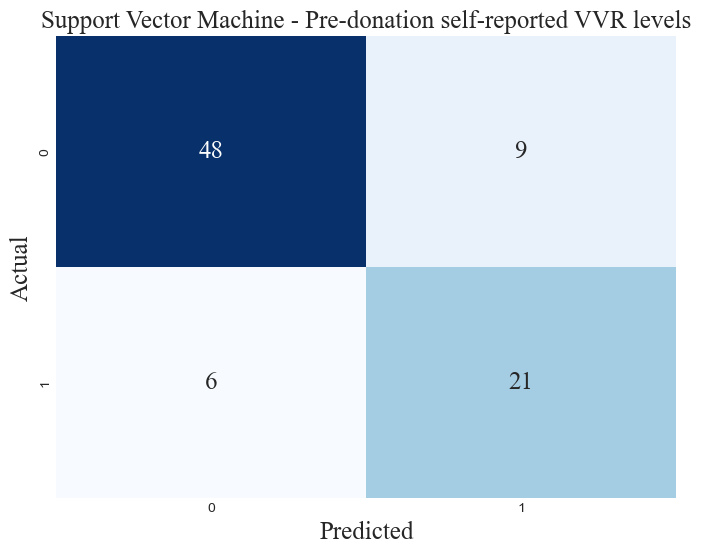

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Support Vector Machine - Pre-donation self-reported VVR levels', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()

# Error analysis

In [13]:
display(X_test)

,Sum_1,Sum_2
0,10.0,9.0
1,14.0,12.0
2,9.0,8.0
3,17.0,19.0
4,10.0,9.0
...,...,...
79,10.0,12.0
80,9.0,8.0
81,10.0,10.0
82,12.0,10.0


In [11]:
X_test_gender = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_test_gender_15-06-2024.csv')

In [12]:
display(X_test_gender)

,Unnamed: 0,Gender,Condition,Sum_456,Sum_4567,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,30,2,1,26.0,34.0,10.0,9.0,-0.394144,0.113788,0.253906,...,0.435610,0.096632,0.288670,0.368635,-0.626277,-0.010494,0.110803,-0.141865,0.104892,0.106922
1,126,2,3,34.0,43.0,14.0,12.0,0.825099,-0.190659,-0.069153,...,1.666168,0.425279,1.754932,1.737696,0.524330,-0.520376,-0.504625,0.864866,-0.575572,-0.536034
2,199,1,3,24.0,32.0,9.0,8.0,0.286661,0.569833,0.692545,...,-0.001568,0.425279,0.076727,0.030450,-0.968274,-0.966036,-1.148606,-2.450403,-1.112739,-1.163339
3,142,2,2,57.0,66.0,17.0,19.0,2.340946,0.853918,0.944420,...,2.000224,0.425279,1.243322,1.681337,1.646689,0.774393,0.910237,0.864866,0.405610,0.795791
4,253,2,3,25.0,33.0,10.0,9.0,-1.091775,-1.363165,-1.790147,...,0.880432,0.425279,0.570028,0.745445,0.147565,0.090425,0.222041,0.864866,-0.205765,0.114488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,92,1,3,30.0,39.0,10.0,12.0,0.586570,-0.251573,-0.137412,...,1.589020,0.425279,1.907163,1.772730,0.511612,-0.405438,-0.356858,0.049067,-0.069567,-0.290302
80,173,1,3,24.0,32.0,9.0,8.0,1.352037,2.449155,2.157521,...,-1.232566,-0.733634,-0.857109,-1.078772,-0.457404,-0.382910,-0.328588,-0.714660,-0.291292,-0.328794
81,55,2,1,26.0,34.0,10.0,10.0,-0.997972,-0.092138,0.038534,...,-1.453697,-1.166064,-1.374354,-1.450532,-0.990030,-0.145579,-0.042962,0.864866,-0.062437,-0.053038
82,251,1,3,28.0,38.0,12.0,10.0,-0.331540,-0.829194,-0.868273,...,-0.839698,-0.543365,-0.677054,-0.783841,-0.145438,-0.223852,-0.134841,-0.315439,-0.185071,-0.154475


In [13]:
columns_to_drop = ['Unnamed: 0', 'Condition', 'Sum_456', 'Sum_4567', 'AU01_r__sum_values', 'AU01_r__variance', 'AU01_r__standard_deviation', 'AU01_r__maximum', 'AU01_r__mean', 'AU01_r__root_mean_square', 'AU02_r__sum_values', 'AU02_r__variance', 'AU02_r__standard_deviation', 'AU02_r__maximum', 'AU02_r__mean', 'AU02_r__root_mean_square', 'AU04_r__sum_values', 'AU04_r__variance', 'AU04_r__standard_deviation', 'AU04_r__maximum', 'AU04_r__mean', 'AU04_r__root_mean_square', 'AU05_r__sum_values', 'AU05_r__variance', 'AU05_r__standard_deviation', 'AU05_r__maximum', 'AU05_r__mean', 'AU05_r__root_mean_square', 'AU06_r__sum_values', 'AU06_r__variance', 'AU06_r__standard_deviation', 'AU06_r__maximum', 'AU06_r__mean', 'AU06_r__root_mean_square', 'AU07_r__sum_values', 'AU07_r__variance', 'AU07_r__standard_deviation', 'AU07_r__maximum', 'AU07_r__mean', 'AU07_r__root_mean_square', 'AU09_r__sum_values', 'AU09_r__variance', 'AU09_r__standard_deviation', 'AU09_r__maximum', 'AU09_r__mean', 'AU09_r__root_mean_square', 'AU10_r__sum_values', 'AU10_r__variance', 'AU10_r__standard_deviation', 'AU10_r__maximum', 'AU10_r__mean', 'AU10_r__root_mean_square', 'AU12_r__sum_values', 'AU12_r__variance', 'AU12_r__standard_deviation', 'AU12_r__maximum', 'AU12_r__mean', 'AU12_r__root_mean_square', 'AU14_r__sum_values', 'AU14_r__variance', 'AU14_r__standard_deviation', 'AU14_r__maximum', 'AU14_r__mean', 'AU14_r__root_mean_square', 'AU15_r__sum_values', 'AU15_r__variance', 'AU15_r__standard_deviation', 'AU15_r__maximum', 'AU15_r__mean', 'AU15_r__root_mean_square', 'AU17_r__sum_values', 'AU17_r__variance', 'AU17_r__standard_deviation', 'AU17_r__maximum', 'AU17_r__mean', 'AU17_r__root_mean_square', 'AU20_r__sum_values', 'AU20_r__variance', 'AU20_r__standard_deviation', 'AU20_r__maximum', 'AU20_r__mean', 'AU20_r__root_mean_square', 'AU23_r__sum_values', 'AU23_r__variance', 'AU23_r__standard_deviation', 'AU23_r__maximum', 'AU23_r__mean', 'AU23_r__root_mean_square', 'AU25_r__sum_values', 'AU25_r__variance', 'AU25_r__standard_deviation', 'AU25_r__maximum', 'AU25_r__mean', 'AU25_r__root_mean_square', 'AU26_r__sum_values', 'AU26_r__variance', 'AU26_r__standard_deviation', 'AU26_r__maximum', 'AU26_r__mean', 'AU26_r__root_mean_square', 'AU45_r__sum_values', 'AU45_r__variance', 'AU45_r__standard_deviation', 'AU45_r__maximum', 'AU45_r__mean', 'AU45_r__root_mean_square']

In [14]:
X_test_gender = X_test_gender.drop(columns=columns_to_drop, axis=1)

In [15]:
display(X_test_gender)

,Gender,Sum_1,Sum_2
0,2,10.0,9.0
1,2,14.0,12.0
2,1,9.0,8.0
3,2,17.0,19.0
4,2,10.0,9.0
...,...,...,...
79,1,10.0,12.0
80,1,9.0,8.0
81,2,10.0,10.0
82,1,12.0,10.0


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

font = 'Times New Roman'
size = 24

def error_analysis(y_test, y_pred, gender):
    """Performs error analysis on gender, including classification report and confusion matrix."""
    error_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'gender': gender})
    error_df['error'] = error_df['y_test'] != error_df['y_pred']
    
    error_by_gender = error_df.groupby('gender')['error'].mean()
    print("\nError analysis by gender:")
    print(error_by_gender)
    
    for gender_group in error_df['gender'].unique():
        gender_label = 'Male' if gender_group == 1 else 'Female'
        print(f"\nClassification Report for gender: {gender_label}")
        gender_indices = error_df['gender'] == gender_group
        y_test_gender = y_test[gender_indices]
        y_pred_gender = y_pred[gender_indices]
        print(classification_report(y_test_gender, y_pred_gender))
        
        conf_matrix = confusion_matrix(y_test_gender, y_pred_gender)

        # Set the style to a modern style
        plt.style.use('seaborn-darkgrid')

        # Create a custom diverging color map
        colors = sns.color_palette("Blues", as_cmap=True)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
                    annot_kws={'fontname': font, 'fontsize': 34})  # Set font and size for numbers
        plt.title(f'Confusion Matrix for {gender_label}', fontname=font, fontsize=size)
        plt.xlabel('Predicted', fontname=font, fontsize=size)
        plt.ylabel('Actual', fontname=font, fontsize=size)

        # Set the font properties for x and y tick labels
        plt.xticks(fontsize=size, fontname=font)
        plt.yticks(fontsize=size, fontname=font)

        plt.show()
    
    return error_by_gender


In [17]:
gender = X_test_gender['Gender']

In [23]:
print(y_test.shape)
print(y_test_pred.shape)
print(gender.shape)


(84,)
(84, 1)
(84,)


In [25]:
y_test_pred = y_test_pred.values.reshape(-1)

In [26]:
print(y_test.shape)
print(y_test_pred.shape)
print(gender.shape)


(84,)
(84,)
(84,)


In [18]:
print(gender)

0     2
1     2
2     1
3     2
4     2
     ..
79    1
80    1
81    2
82    1
83    1
Name: Gender, Length: 84, dtype: int64



Error analysis by gender:
gender
1    0.135135
2    0.212766
Name: error, dtype: float64

Classification Report for gender: Female
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        29
           1       0.70      0.78      0.74        18

    accuracy                           0.79        47
   macro avg       0.78      0.79      0.78        47
weighted avg       0.79      0.79      0.79        47



/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_33959/310982882.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


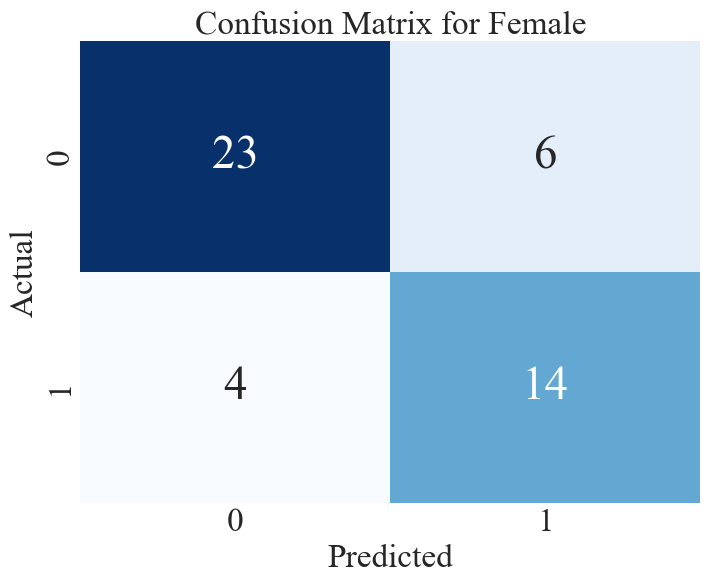


Classification Report for gender: Male
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        28
           1       0.70      0.78      0.74         9

    accuracy                           0.86        37
   macro avg       0.81      0.84      0.82        37
weighted avg       0.87      0.86      0.87        37



/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_33959/310982882.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


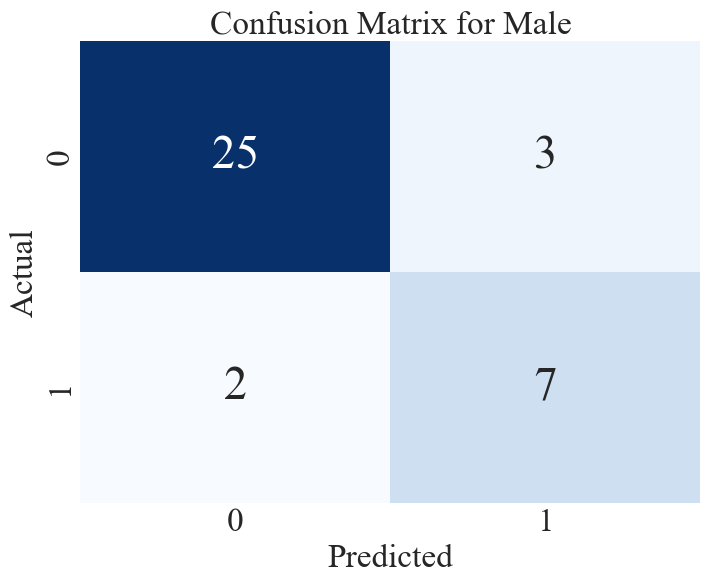

In [35]:
error_by_gender = error_analysis(y_test, y_test_pred, gender)


In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve

def plot_curves(y_test, y_proba, y_pred, font, size):
    """Plots PR and ROC curves with specified font and size."""
    # Plot Precision-Recall curve
    fig_size = (8, 6)  # Define a common figure size


    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    
    plt.figure(figsize=fig_size)
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall', fontname=font, fontsize=size)
    plt.ylabel('Precision', fontname=font, fontsize=size)
    # plt.title('Precision-Recall Curve', fontname=font, fontsize=size)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=size)
    plt.xticks(fontname=font, fontsize=size)
    plt.yticks(fontname=font, fontsize=size)
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate', fontname=font, fontsize=size)
    plt.ylabel('True Positive Rate', fontname=font, fontsize=size)
    # plt.title('ROC Curve', fontname=font, fontsize=size)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=size)
    plt.xticks(fontname=font, fontsize=size)
    plt.yticks(fontname=font, fontsize=size)
    plt.show()


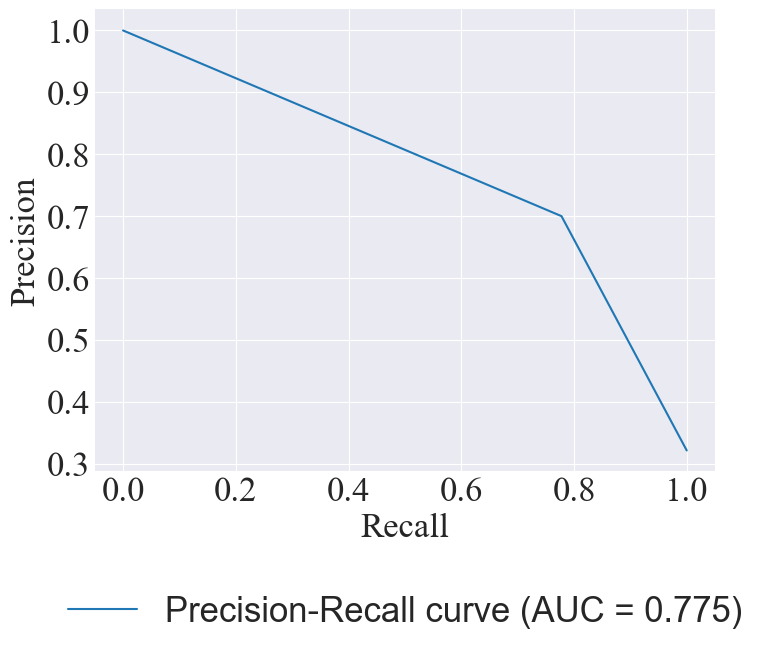

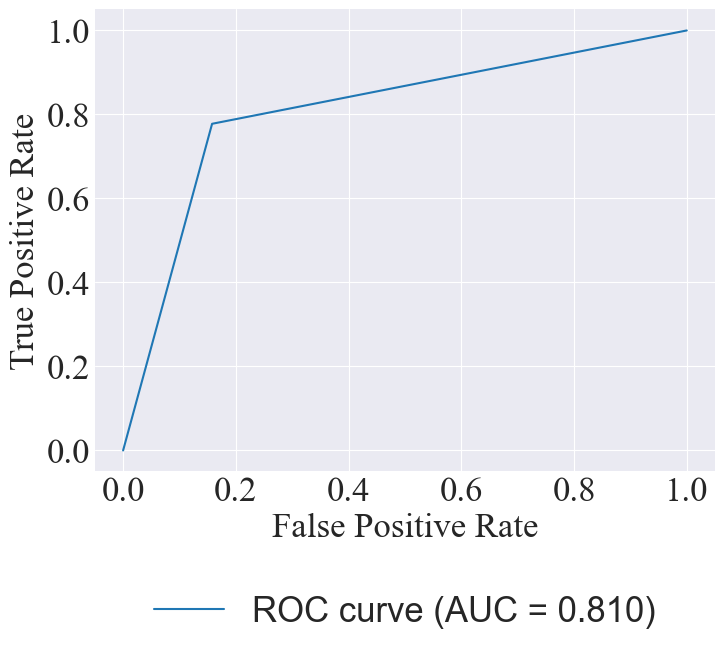

In [64]:
# Assuming y_test, y_test_proba, and y_test_pred are already defined and saved

# Example usage with adjusted font and size
plot_curves(y_test, y_test_pred, y_test_pred, font='Times New Roman', size=25)


# Graph that shows Sum of VVR scores and classification 

In [31]:
y_test_pred = pd.read_csv('/Users/dionnespaltman/Desktop/V6/02_svm_y_test_pred_18-06-2024.csv')

In [66]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [67]:
copy_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_test_13-06-2024.csv')
display(copy_test)

,Unnamed: 0,Condition,Sum_456,Sum_4567,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,30,1,26.0,34.0,10.0,9.0,-0.394144,0.113788,0.253906,-0.241433,...,0.435610,0.096632,0.288670,0.368635,-0.626277,-0.010494,0.110803,-0.141865,0.104892,0.106922
1,126,3,34.0,43.0,14.0,12.0,0.825099,-0.190659,-0.069153,0.293698,...,1.666168,0.425279,1.754932,1.737696,0.524330,-0.520376,-0.504625,0.864866,-0.575572,-0.536034
2,199,3,24.0,32.0,9.0,8.0,0.286661,0.569833,0.692545,-0.091596,...,-0.001568,0.425279,0.076727,0.030450,-0.968274,-0.966036,-1.148606,-2.450403,-1.112739,-1.163339
3,142,2,57.0,66.0,17.0,19.0,2.340946,0.853918,0.944420,0.293698,...,2.000224,0.425279,1.243322,1.681337,1.646689,0.774393,0.910237,0.864866,0.405610,0.795791
4,253,3,25.0,33.0,10.0,9.0,-1.091775,-1.363165,-1.790147,-1.750502,...,0.880432,0.425279,0.570028,0.745445,0.147565,0.090425,0.222041,0.864866,-0.205765,0.114488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,92,3,30.0,39.0,10.0,12.0,0.586570,-0.251573,-0.137412,0.293698,...,1.589020,0.425279,1.907163,1.772730,0.511612,-0.405438,-0.356858,0.049067,-0.069567,-0.290302
80,173,3,24.0,32.0,9.0,8.0,1.352037,2.449155,2.157521,0.293698,...,-1.232566,-0.733634,-0.857109,-1.078772,-0.457404,-0.382910,-0.328588,-0.714660,-0.291292,-0.328794
81,55,1,26.0,34.0,10.0,10.0,-0.997972,-0.092138,0.038534,0.293698,...,-1.453697,-1.166064,-1.374354,-1.450532,-0.990030,-0.145579,-0.042962,0.864866,-0.062437,-0.053038
82,251,3,28.0,38.0,12.0,10.0,-0.331540,-0.829194,-0.868273,0.293698,...,-0.839698,-0.543365,-0.677054,-0.783841,-0.145438,-0.223852,-0.134841,-0.315439,-0.185071,-0.154475


In [68]:
display(X_test)

,Sum_1,Sum_2
0,10.0,9.0
1,14.0,12.0
2,9.0,8.0
3,17.0,19.0
4,10.0,9.0
...,...,...
79,10.0,12.0
80,9.0,8.0
81,10.0,10.0
82,12.0,10.0


In [69]:
assert len(copy_test['Sum_4567']) == len(y_test) == len(y_test_pred), "All input arrays must have the same length"

In [74]:
# Convert the dataframe to a numpy array
y_test_pred = y_test_pred.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [75]:
print(copy_test['Sum_4567'].shape)
print(y_test.shape)
print(y_test_pred.shape)

(84,)
(84, 1)
(84,)


In [76]:
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_test_12-06-2024.csv')
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

In [71]:
print(copy_test['Sum_4567'])


0     34.0
1     43.0
2     32.0
3     66.0
4     33.0
      ... 
79    39.0
80    32.0
81    34.0
82    38.0
83    46.0
Name: Sum_4567, Length: 84, dtype: float64


In [77]:
print(copy_test['Sum_4567'].shape)
print(y_test.shape)
print(y_test_pred.shape)

(84,)
(84, 1)
(84,)


In [80]:
y_test = y_test.values.reshape(-1)
print(y_test.shape)  # Should print (84,)

(84,)


In [81]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'VVR_scores': copy_test['Sum_4567'],
    'y_test': y_test,
    'y_test_pred': y_test_pred
}

df = pd.DataFrame(data)

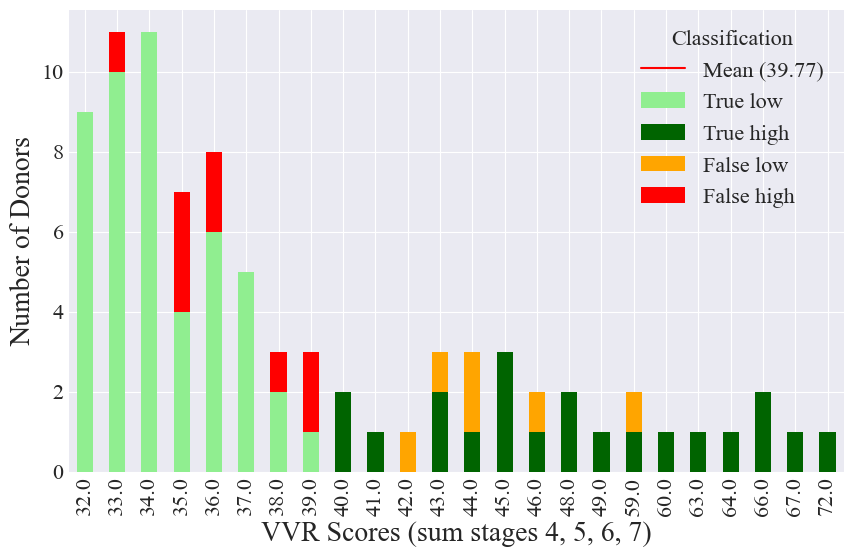

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

font = 20

# Add classification labels
df['classification'] = 'false high'
df.loc[(df['y_test'] == 0) & (df['y_test_pred'] == 0), 'classification'] = 'True low'
df.loc[(df['y_test'] == 1) & (df['y_test_pred'] == 1), 'classification'] = 'True high'
df.loc[(df['y_test'] == 0) & (df['y_test_pred'] == 1), 'classification'] = 'False high'
df.loc[(df['y_test'] == 1) & (df['y_test_pred'] == 0), 'classification'] = 'False low'

# Group and count by VVR_score and classification
grouped = df.groupby(['VVR_scores', 'classification']).size().unstack(fill_value=0)

# Reorder columns to ensure "true low" and "true high" are at the bottom of the stack
grouped = grouped[['True low', 'True high', 'False low', 'False high']]

# Colors for the classifications
colors = {
    'True low': 'lightgreen',
    'True high': 'darkgreen',
    'False low': 'orange',
    'False high': 'red'
}

# Set font to Times New Roman
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman'})

# Plot the stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors.get(x) for x in grouped.columns])

# Add the mean VVR score as a vertical dotted line
mean_vvr_score = 39.77
plt.axvline(x=mean_vvr_score, color='red', linestyle='-', label=f'Mean ({mean_vvr_score:.2f})', zorder=5)

# Set font sizes
plt.xlabel('VVR Scores (sum stages 4, 5, 6, 7)', fontsize=font)
plt.ylabel('Number of Donors', fontsize=font)
# plt.title('Classification of Donors by VVR Scores', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add legend with adjusted font size
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Classification', fontsize=16, title_fontsize=16)

plt.show()
